# Ускорение AB тестов:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [3]:
import os
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import hashlib
from base64 import b64encode
import warnings

In [144]:
warnings.filterwarnings("ignore")

In [8]:
PATH = ""
shop_metrics_new = pd.read_csv(PATH + 'shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv(PATH + 'shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

# 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни:

In [4]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [5]:
def salt_generator(salt=None):
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

In [6]:
def groups_splitter(df, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

In [26]:
def compute_power_correctness(df, metric, test_fn, effect=0.05, n=100):
    correctness = []
    power = []
    
    shop = df.drop(columns=['group'])
    
    for i in tqdm(range(n)):
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        
        vec_a = new_df[(new_df['group'] == 'A')][metric]
        vec_b = new_df[(new_df['group'] == 'B')][metric]
        vec_b_effect = vec_b * (1 + effect)
        p_cor, p_power = test_fn(vec_a, vec_b)[1], test_fn(vec_a, vec_b_effect)[1]
        correctness.append(p_cor)
        power.append(p_power)
        
    correctness = np.array(correctness)
    
    sns.set(rc={'figure.figsize':(4.7,4.27)})
    sns.histplot(data=correctness, bins=10, color='brown', kde=True)
    
    correctness_value = (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0]))
    
    
    power = np.array(power)
    power_value = (power[power < 0.05].shape[0] / power.shape[0])

    
    print(f'CORRECTNESS: {correctness_value * 100}%% ')
    print()
    print(f'POWER: {power_value * 100}%')

**Метрика cart_added_cnt (5 баллов)**

In [9]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

  0%|          | 0/100 [00:00<?, ?it/s]

CORRECTNESS: 99.0%% 

POWER: 100.0%


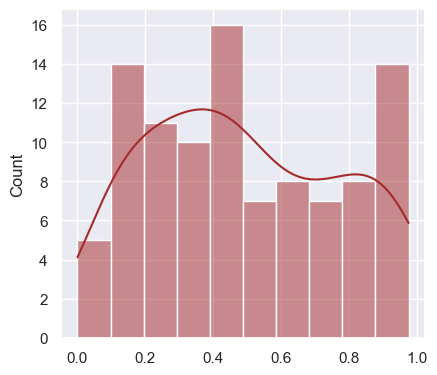

In [23]:
compute_power_correctness(ranked, 'rank', stats.ttest_ind)

  0%|          | 0/100 [00:00<?, ?it/s]

CORRECTNESS: 97.0%% 

POWER: 100.0%


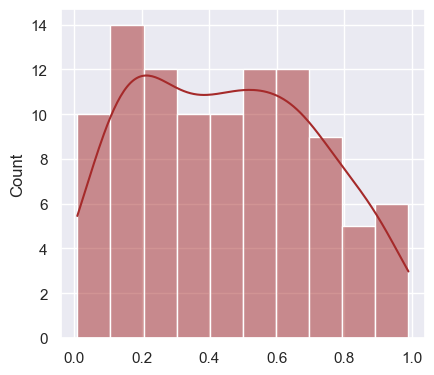

In [27]:
compute_power_correctness(shop_metrics_new, 'cart_added_cnt', stats.mannwhitneyu)

У обоих тестов высокая мощность, однако у теста с ранговой трансформацией более высокая корректность.

In [15]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

In [17]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

В обоих случаях p-value получилось почти одинаковым: примерно 0.2. Это означает, что статичтически значимых различий в метрике cart_added_cnt между группами нет.

Тот факт, что результаты двух тестов получились похожими, ожидаем, так как оба метода работают с ранговыми данными.

**Вывод:** t-тест с ранговой трансформация обоадает более высокой корректностью, чем тест Манна-Уитни, но в целом такие тесты дают схожие результаты.

# **2. Реализовать cuped-трансформацию и сравнить мощность t-критерия**:

**обычная метрика cart_added_cnt (5 баллов)**

In [142]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [43]:
def get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, metric):
    shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', metric]], on=['user_id'], how='left')
    shop_metrics_all = shop_metrics_all\
                   .rename(columns={f'{metric}_x': f'{metric}', f'{metric}_y': f'{metric}_covariate'})
    shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [metric])
    return shop_metrics_all_cuped

In [147]:
shop_metrics_all_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt')

In [46]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128448428, pvalue=0.1658736404876475, df=222519.0)

In [178]:
def get_vecs(df, metric, effect=0.05, ranked=False, log=False):
    vec_a = df[(df['group'] == 'A')][metric]
    vec_b = df[(df['group'] == 'B')][metric]
    if log:
        vec_b_effect = vec_b + np.log(1 + effect)
    else:
        vec_b_effect = vec_b * (1 + effect)
    if ranked:
        df_b = df[df.group == 'B'].drop(columns=[metric])
        df_b[metric] = list(vec_b_effect)
        ranked_df_effect = rank_transformation(df[df.group == 'A'], df_b, metric)
        vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
        vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']
        return vec_a_power, vec_b_power
    return vec_a, vec_b_effect
    

def compare_power_cuped(shop_metrics_new, shop_metrics_old, metric, effect=0.05, n=100, ranked=False, log=False):
    
    shop = shop_metrics_new.drop(columns=['group'])

    power = []
    power_cuped = []
    
    for i in tqdm(range(n)):
    
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        all_df = pd.merge(new_df, shop_metrics_old[['user_id', metric]], on=['user_id'], how='left')
        all_df = all_df.rename(columns={f'{metric}_x': metric, f'{metric}_y': f'{metric}_covariate'})
        cuped_df = cuped_transform(all_df, [metric])
    
        vec_a_power, vec_b_power = get_vecs(all_df, metric, effect=effect, ranked=ranked)
        vec_a_cuped_power, vec_b_cuped_power = get_vecs(cuped_df, f'{metric}_cuped', effect=effect, ranked=ranked)
        
        
        p_power, p_power_cuped = stats.ttest_ind(vec_a_power, vec_b_power)[1], stats.ttest_ind(vec_a_cuped_power, vec_b_cuped_power)[1]
        power.append(p_power)
        power_cuped.append(p_power_cuped)
    
    power = np.array(power)
    power_cuped = np.array(power_cuped)

    power_value = (power[power < 0.05].shape[0] / power.shape[0])
    power_cuped_value = (power_cuped[power_cuped < 0.05].shape[0] / power_cuped.shape[0])
    
    print(f'POWER:\nбез cuped: {power_value * 100}%\tcuped: {power_cuped_value * 100}% ')
    return power_value, power_cuped_value

In [102]:
compare_power_cuped(shop_metrics_new, shop_metrics_old, 'cart_added_cnt', effect=0.05, n=100)

  0%|          | 0/100 [00:00<?, ?it/s]

POWER:
без cuped: 63.0%	cuped: 100.0% 


(0.63, 1.0)

После применения CUPED-трансформации дисперсия метрики cart_added_cnt уменьшилась, что позволило увеличить мощность t-критерия. Результаты показали, что мощность выросла с 63% до 100%, что указывает на более высокую вероятность выявления статистически значимого эффекта, если он существует.

**логарфимированная метрика cart_added_cnt (5 баллов)**

In [169]:
shop_metrics_new['cart_added_cnt_ln'] = shop_metrics_new['cart_added_cnt'].apply(lambda x: np.log(x+1))
shop_metrics_old['cart_added_cnt_ln'] = shop_metrics_old['cart_added_cnt'].apply(lambda x: np.log(x+1))

In [170]:
shop_metrics_all_cuped_ln = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt_ln')

In [171]:
stats.ttest_ind(shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == 'A']['cart_added_cnt_ln_cuped'],
                shop_metrics_all_cuped_ln[shop_metrics_all_cuped_ln.group == 'B']['cart_added_cnt_ln_cuped'])

TtestResult(statistic=-2.0493551017037106, pvalue=0.040428574068197394, df=222519.0)

In [179]:
compare_power_cuped(shop_metrics_new, shop_metrics_old, 'cart_added_cnt_ln', effect=0.05, n=100, log=True)

  0%|          | 0/100 [00:00<?, ?it/s]

POWER:
без cuped: 96.0%	cuped: 100.0% 


(0.96, 1.0)

Высокая мощность (96%) говорит о том, что даже без применения CUPED логарифмирование эффективно справляется с задачей. Вероятно, оно помогло уменьшить влияние выбросов или неравномерности распределения данных, что сделало тест достаточно мощным.  
CUPED добавляет небольшой прирост мощности, доводя её до максимального значения. Это указывает на то, что ковариаты всё же помогают минимизировать остаточную вариацию, но их эффект не столь значительный, как для обычной метрики.

**метрика cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)**

In [57]:
ranked_cuped = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
                             shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped')

In [58]:
stats.ttest_ind(ranked_cuped[ranked_cuped.group == 'A']['rank'], ranked_cuped[ranked_cuped.group == 'B']['rank'])

TtestResult(statistic=-1.4459909525623789, pvalue=0.14818114788143424, df=222519.0)

In [114]:
compare_power_cuped(shop_metrics_new, shop_metrics_old, 'cart_added_cnt', effect=0.05, n=100, ranked=True)

  0%|          | 0/100 [00:00<?, ?it/s]

POWER:
без cuped: 100.0%	cuped: 100.0% 


(1.0, 1.0)

Даже без использования CUPED, ранговая метрика уже обладает высокой мощностью (100%). Это может быть связано с тем, что ранжирование устраняет влияние выбросов и делает тест более устойчивым.  
CUPED не привел к заметному улучшению, так как мощность уже была на максимальном уровне.

**Вывод:** CUPED дает наиибольший прирост для обычной метрики (нелогарифмированной и без рангового преобразования).

# **3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:**

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped.

**На логнормальном распределении (сгенерированные данные) (5 баллов)**

In [327]:
shop_metrics_new['lognorm'] = np.random.lognormal(size=len(shop_metrics_new))

In [472]:
shop_metrics_new['lognorm_bucket'] = shop_metrics_new['lognorm'].apply(lambda x: x//10)

In [473]:
shop_metrics_new['lognorm_bucket'].unique()

array([0., 1., 2., 3., 4., 6., 5., 7.])

In [474]:
f"Дисперсия уменьшилась с {shop_metrics_new['lognorm'].std():.2f} до {shop_metrics_new['lognorm_bucket'].std():.2f}"

'Дисперсия уменьшилась с 2.14 до 0.13'

In [475]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['lognorm'], shop_metrics_new[shop_metrics_new.group == 'B']['lognorm'])

TtestResult(statistic=-0.2585141876301902, pvalue=0.7960103399219585, df=222519.0)

In [476]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['lognorm_bucket'], shop_metrics_new[shop_metrics_new.group == 'B']['lognorm_bucket'])

TtestResult(statistic=-0.42883166848605253, pvalue=0.6680461457641562, df=222519.0)

И с бакетированием, и без тест не показал значимых различий между группами. Однако после бакетирования p-value снизилось с 0.8 до 0.67. 

In [485]:
shop_metrics_old['lognorm'] = np.random.lognormal(size=len(shop_metrics_old))
shop_metrics_old['lognorm_bucket'] = shop_metrics_old['lognorm'].apply(lambda x: x//10)

In [491]:
shop_metrics_all_lognorm_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'lognorm')
shop_metrics_all_lognorm_bucket_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'lognorm_bucket')

Равны ли средние в группах в ковариате?

In [487]:
shop_metrics_all_lognorm_cuped.groupby('group')['lognorm_covariate'].mean()

group
A    1.647808
B    1.635398
Name: lognorm_covariate, dtype: float64

In [488]:
shop_metrics_all_lognorm_bucket_cuped.groupby('group')['lognorm_bucket_covariate'].mean()

group
A    0.012154
B    0.011862
Name: lognorm_bucket_covariate, dtype: float64

Средние в группах в ковариате равны с точностью до тысячных и для обычной метрики, и для бакетированной.

Совпадают ли средние в метрике до и после применения cuped?

In [481]:
shop_metrics_new['lognorm'].mean() == shop_metrics_all_lognorm_cuped['lognorm'].mean()

True

In [482]:
shop_metrics_new['lognorm_bucket'].mean() == shop_metrics_all_lognorm_cuped['lognorm_bucket'].mean()

True

Средние в метрике до и после применения cuped совпадают и для обычной метрики, и для бакетированной.

In [489]:
stats.ttest_ind(shop_metrics_all_lognorm_cuped[shop_metrics_all_lognorm_cuped.group == 'A']['lognorm_cuped'],
                shop_metrics_all_lognorm_cuped[shop_metrics_all_lognorm_cuped.group == 'B']['lognorm_cuped'])

TtestResult(statistic=-0.25768483157605837, pvalue=0.7966503918017576, df=222519.0)

In [492]:
stats.ttest_ind(shop_metrics_all_lognorm_bucket_cuped[shop_metrics_all_lognorm_bucket_cuped.group == 'A']['lognorm_bucket_cuped'],
                shop_metrics_all_lognorm_bucket_cuped[shop_metrics_all_lognorm_bucket_cuped.group == 'B']['lognorm_bucket_cuped'])

TtestResult(statistic=-0.43028813685962236, pvalue=0.6669864723046366, df=222519.0)

И для обычной метрики, и для бакетированной применение CUPED почти не изменилос p-value.

**На метрике cart_added_cnt (5 баллов)**

In [495]:
shop_metrics_new['cart_added_cnt'].unique()

array([ 0,  2,  1,  3, 12,  4,  6,  5,  8,  7, 56, 38, 15, 17,  9, 23, 11,
       10, 13, 75, 21, 19, 20, 28, 22, 14, 39, 51, 24, 33, 16, 18, 41, 25,
       61])

In [496]:
shop_metrics_new['cart_added_cnt_bucket'] = shop_metrics_new['cart_added_cnt'].apply(lambda x: x//10)

In [497]:
shop_metrics_new['cart_added_cnt_bucket'].unique()

array([0, 1, 5, 3, 2, 7, 4, 6])

In [498]:
f"Дисперсия уменьшилась с {shop_metrics_new['cart_added_cnt'].std():.2f} до {shop_metrics_new['cart_added_cnt_bucket'].std():.2f}"

'Дисперсия уменьшилась с 0.63 до 0.04'

In [499]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'], shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

TtestResult(statistic=-1.3047727178459143, pvalue=0.1919716009958315, df=222519.0)

In [500]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt_bucket'], shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt_bucket'])

TtestResult(statistic=-0.46024411491481815, pvalue=0.6453414591158615, df=222519.0)

И с бакетированием, и без тест не показал значимых различий между группами. Однако после бакетирования p-value значительно увеличилось (с 0.19 до 0.65). Вероятно, бакетирование сильно "размыло" различие между группами: пропало различие между теми, кто положил в корзину 9 товаров и 0 товаров.

In [507]:
shop_metrics_old['cart_added_cnt_bucket'] = shop_metrics_old['cart_added_cnt'].apply(lambda x: x//10)

In [508]:
shop_metrics_all_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt')
shop_metrics_all_bucket_cuped = get_cuped_transformed_df(shop_metrics_new, shop_metrics_old, 'cart_added_cnt_bucket')

Равны ли средние в группах в ковариате?

In [509]:
shop_metrics_all_cuped.groupby('group')['cart_added_cnt_covariate'].mean()

group
A    0.140557
B    0.143426
Name: cart_added_cnt_covariate, dtype: float64

In [510]:
shop_metrics_all_bucket_cuped.groupby('group')['cart_added_cnt_bucket_covariate'].mean()

group
A    0.000674
B    0.000764
Name: cart_added_cnt_bucket_covariate, dtype: float64

Средние в группах в ковариате равны с точностью до сотых для обычной метрики и с точностью до тысячных для бакетированной метрики.

Совпадают ли средние в метрике до и после применения cuped?

In [459]:
shop_metrics_new['cart_added_cnt'].mean() == shop_metrics_all_cuped['cart_added_cnt'].mean()

True

In [460]:
shop_metrics_new['cart_added_cnt_bucket'].mean() == shop_metrics_all_bucket_cuped['cart_added_cnt_bucket'].mean()

True

Средние в метрике до и после применения cuped совпадают и для обычной метрики, и для бакетированной.

In [511]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=-1.3855896128448428, pvalue=0.1658736404876475, df=222519.0)

In [512]:
stats.ttest_ind(shop_metrics_all_bucket_cuped[shop_metrics_all_bucket_cuped.group == 'A']['cart_added_cnt_bucket_cuped'],
                shop_metrics_all_bucket_cuped[shop_metrics_all_bucket_cuped.group == 'B']['cart_added_cnt_bucket_cuped'])

TtestResult(statistic=0.22875639879432447, pvalue=0.8190584671361374, df=222519.0)

Для обычной метрики применение CUPED уменьшило p-value (0.19 -> 0.17), а для бакетированной, наоборот, увеличило (0.65 -> 0.82).

**Выводы:**
- Для логнормальных метрик бакетирование полезно, так как оно уменьшает дисперсию и устраняет выбросы.
- Для метрик с низкой дисперсией (например, целочисленных, таких как cart_added_cnt), лучше избегать излишне крупного бакетирования, чтобы сохранить различия между группами.

# **4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:**

**На сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)**

In [148]:
shop_users_info

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m
...,...,...,...
407278,1515915625611023671,76,m
407279,1515915625611023730,34,m
407280,1515915625611024014,62,m
407281,1515915625611024020,48,f


In [191]:
from math import inf

def get_strf_group(x, sex=True, age=True):
    assert sex or age, 'Stratification should be by sex or/and age'
    group = x['user_sex'] if sex else ''
    if age:
        age_groups = [(18, 24), (25, 45), (46, 60), (61, 75), (76, inf)]
        for minlim, maxlim in age_groups:
            if minlim <= x['user_age'] <= maxlim:
                group += f'_{minlim}-{maxlim}'
    return group

In [192]:
def poststratify(df, sex=True, age=True):
    shop_w_features = pd.merge(df, shop_users_info, on=['user_id'], how='left')
    shop_w_features['strf'] = shop_w_features.apply(lambda x: get_strf_group(x, sex=sex, age=age), axis=1)
    return shop_w_features

In [187]:
shop_w_features = poststratify(shop_metrics_old)

In [162]:
shop_w_features['sex_age_group'].unique()

array(['f_46-60', 'm_46-60', 'f_18-24', 'm_25-45', 'f_25-45', 'm_76-inf',
       'm_61-75', 'f_61-75', 'f_76-inf', 'm_18-24'], dtype=object)

In [164]:
stats.ttest_ind(shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'],
                shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'])

TtestResult(statistic=-0.7331870372707812, pvalue=0.4634447828246868, df=406861.0)

In [194]:
def test_poststratified(shop_w_features, metric, feature='strf', verbose=True):
    N = shop_w_features['user_id'].nunique()
    
    strats_weights = {}
    
    mean_a, mean_b, std_a, std_b = 0, 0, 0, 0
    
    for i in range(0, shop_w_features[feature].nunique()):
        key = shop_w_features[feature].value_counts().index[i]
        strats_weights[key] = shop_w_features[feature].value_counts()[i] / N
        mean_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features[feature] == key)][metric].mean() * strats_weights[key]
        mean_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features[feature] == key)][metric].mean() * strats_weights[key]
        std_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features[feature] == key)][metric].std()**2 * strats_weights[key]
        std_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features[feature] == key)][metric].std()**2 * strats_weights[key]
    
    n_a = len(shop_w_features[shop_w_features.group == 'A'])
    n_b = len(shop_w_features[shop_w_features.group == 'B'])
    
    if verbose:
        print(f'effect: {(mean_b - mean_a)/mean_a*100}, std_a: {std_a}, std_b: {std_b}')

    return stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

In [515]:
test_poststratified(shop_w_features, 'cart_added_cnt')

effect: 1.1238909894351434, std_a: 0.33278038455229625, std_b: 0.3586264542191377


Ttest_indResult(statistic=-1.2454768228689563, pvalue=0.2129572471320501)

И с постстратификацией, и без тест не показал значимых различий между группами. Однако с постстратификацией p-value почти в два раза ниже. 
Возможно, для каких-то половозрастных групп различия между группами A и B более выражены. Проверим это.

In [535]:
for key in sorted(shop_w_features['strf'].unique()):
    print(key)
    print(stats.ttest_ind(shop_w_features[shop_w_features['strf'] == key][shop_w_features.group == 'A']['cart_added_cnt'],
                shop_w_features[shop_w_features['strf'] == key][shop_w_features.group == 'B']['cart_added_cnt']))

f_18-24
TtestResult(statistic=-1.266858540599369, pvalue=0.20522328237478235, df=16950.0)
f_25-45
TtestResult(statistic=-0.39299361960582735, pvalue=0.6943258372048688, df=50977.0)
f_46-60
TtestResult(statistic=-1.3735823653700876, pvalue=0.1695798236274159, df=36445.0)
f_61-75
TtestResult(statistic=0.9180034589371632, pvalue=0.3586231740161858, df=36183.0)
f_76-inf
TtestResult(statistic=-2.0457070205331305, pvalue=0.040796961236604166, df=22205.0)
m_18-24
TtestResult(statistic=0.4675950776514708, pvalue=0.6400781497721612, df=25704.0)
m_25-45
TtestResult(statistic=0.5809968635854353, pvalue=0.5612442696570454, df=76920.0)
m_46-60
TtestResult(statistic=-0.6842568711378716, pvalue=0.4938158800493182, df=54602.0)
m_61-75
TtestResult(statistic=0.11940596450181902, pvalue=0.9049541782696899, df=54248.0)
m_76-inf
TtestResult(statistic=0.48092299846201075, pvalue=0.6305744531876034, df=32609.0)


In [534]:
shop_users_info.groupby('user_sex').count()[['user_id']]

,user_id
user_sex,
f,162918
m,244365


Действительно, для женщин p-value в среднем ниже, чем для мужчин. Причем для женщин 76+ различия статистически значимы. При этом мужчин в выборке намного больше, засчет чего в тесте без постстратификации эффект теряется.

**Проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)**

In [197]:
def compare_power_correctness_posstratified(df, metric, effect=0.05, n=100, sex=True, age=True):
    correctness = []
    power = []
    
    correctness_pststrf = []
    power_pststrf = []
    
    shop = df.drop(columns=['group'])
    
    for i in tqdm(range(n)):
    
        new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
        shop_w_features = poststratify(new_df, sex=sex, age=age)
        
        vec_a = new_df[(new_df['group'] == 'A')][metric]
        vec_b = new_df[(new_df['group'] == 'B')][metric]
        vec_b_effect = vec_b * (1 + effect)
        p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
        correctness.append(p_cor)
        power.append(p_power)
    
    
        shop_w_features_w_effect = shop_w_features.copy()
        shop_w_features_w_effect[metric] = shop_w_features_w_effect.apply(lambda x: x[metric]*(1 + effect) if x.group == 'B' else x[metric], axis=1)
        
        p_cor_pststrf, p_power_pststrf = test_poststratified(shop_w_features, metric, verbose=False)[1], test_poststratified(shop_w_features_w_effect, metric, verbose=False)[1]
        correctness_pststrf.append(p_cor_pststrf)
        power_pststrf.append(p_power_pststrf)
        
    
    correctness = np.array(correctness)
    correctness_pststrf = np.array(correctness_pststrf)
    
    sns.set(rc={'figure.figsize':(4.7,4.27)})
    sns.histplot(data=correctness, bins=10, color='brown', kde=True)
    sns.histplot(data=correctness_pststrf, bins=10, color='blue', kde=True)
    
    correctness_value = (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0]))
    correctness_pststrf_value = (1 - (correctness_pststrf[correctness_pststrf < 0.05].shape[0] / correctness_pststrf.shape[0]))
    
    
    power = np.array(power)
    power_pststrf = np.array(power_pststrf)
    
    power_value = (power[power < 0.05].shape[0] / power.shape[0])
    power_pststrf_value = (power_pststrf[power_pststrf < 0.05].shape[0] / power_pststrf.shape[0])

    
    print(f'Постстратификация (по полу={sex}\tпо возрасту={age})')
    print()
    print(f'CORRECTNESS:\nбез постстратификации: {correctness_value * 100}%\tс постстратификацией: {correctness_pststrf_value * 100}% ')
    print()
    print(f'POWER:\nбез постстратификации: {power_value * 100}%\tс постстратификацией: {power_pststrf_value * 100}% ')

  0%|          | 0/100 [00:00<?, ?it/s]

Постстратификация (по полу=True	по возрасту=True)

CORRECTNESS:
без постстратификации: 95.0%	с постстратификацией: 78.0% 

POWER:
без постстратификации: 90.0%	с постстратификацией: 97.0% 


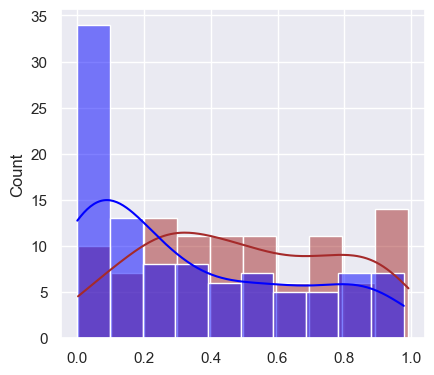

In [201]:
compare_power_correctness_posstratified(shop_metrics_old, 'cart_added_cnt', n=100)

Корректность снижается c 97% до 83%, что может указывать на увеличение вероятности ложных срабатываний после постстратификации. Постстратификация могла внести искажения или недостаточно хорошо учесть групповые различия, что снизило способность теста правильно интерпретировать отсутствие эффекта.

Постстратификация слегка увеличила мощность c 94% до 98%, что говорит о лучшей способности обнаруживать реальные различия между группами после учета пола и возрастных групп.

**Вывод:** Постстратификация эффективна, если группы пола и возраста значимо влияют на метрику. Если их влияние минимально, постстратификация может вносить лишний шум, снижая корректность.